In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

In [7]:
def compute_covariance_matrix(data: pd.DataFrame, start_date: str = None, end_date: str = None) -> pd.DataFrame:
    """
    Compute the covariance matrix for a given initial and final date.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing stock return data.
    start_date (str): Initial date in 'YYYY-MM-DD' format.
    end_date (str): Final date in 'YYYY-MM-DD' format.
    
    Returns:
    pd.DataFrame: Sorted covariance matrix. The sort is based on the highest varaince.
    """
    if start_date and end_date:
        # Filter data for the specified date range
        filtered_data = data[(data.index >= start_date) and (data.index <= end_date)]
    else:
        filtered_data = data
        
    # Compute the covariance matrix
    covariance_matrix = filtered_data.cov()
    diag_elements = np.diag(covariance_matrix)
    sorted_indices = np.argsort(diag_elements)[::-1]
    covariance_matrix = covariance_matrix.iloc[sorted_indices, sorted_indices]
    
    return covariance_matrix

def calculate_scalar_volatility_metric(returns, period=14):

    # Compute the standard deviation of returns (amplitude of fluctuations)
    amplitude = returns.rolling(window=period).std().mean()

    # Calculate the frequency of sign changes in returns (frequency of ups and downs)
    sign_changes = np.sign(returns).diff().fillna(0).abs()
    frequency = sign_changes.rolling(window=period).mean().mean()

    # Combine amplitude and frequency into a single metric
    scalar_volatility_metric = amplitude * frequency
    
    return scalar_volatility_metric

def compute_scalar_volatility_matrix(data: pd.DataFrame, period=14, start_date: str = None, end_date: str = None) -> pd.Series:
    """
    Compute and sort the scalar volatility metric for each stock, incorporating both amplitude and frequency of price movements.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing stock closing price data with dates as index and stock names as columns.
    period (int): Period to compute the volatility metric.
    start_date (str): Initial date in 'YYYY-MM-DD' format.
    end_date (str): Final date in 'YYYY-MM-DD' format.
    
    Returns:
    pd.Series: Scalar volatility metrics sorted in descending order.
    """
    if start_date and end_date:
        data = data.loc[start_date:end_date]
    
    scalar_volatility_metrics = {}

    for stock in data.columns:
        stock_prices = data[stock]
        scalar_volatility_metrics[stock] = calculate_scalar_volatility_metric(stock_prices, period)
    
    sorted_scalar_volatility_metrics = pd.Series(scalar_volatility_metrics).sort_values(ascending=False)
    
    return sorted_scalar_volatility_metrics

# Usage example:
# Assume df is a DataFrame with Dates as the index and stock names as columns, containing closing prices.


In [3]:
# Fetch the current list of S&P 500 constituents
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_table = pd.read_html(sp500_url)
sp500_df = sp500_table[0]
# Define the period
start_date = '2024-01-01'
end_date = '2024-08-07'

# Extract the list of tickers
sp500_tickers = sp500_df['Symbol'].tolist()
try:
    with open('s&p500_new.csv', 'r') as file:
        data = pd.read_csv(file)
except FileNotFoundError:
    data = yf.download(sp500_tickers, start=start_date, end=end_date)['Adj Close']
data = data.reset_index()

# Rename the columns
data.columns.name = None  # Remove the name of the columns index
data = data.rename(columns={'index': 'Date'})
data.set_index('Date', inplace=True)
data = data.pct_change()
data.fillna(0, inplace=True)

[**********************61%%***                   ]  307 of 503 completed

$BF.B: possibly delisted; No price data found  (1d 2024-01-01 -> 2024-08-07)


[*********************100%%**********************]  503 of 503 completed

2 Failed downloads:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-01-01 -> 2024-08-07)')


# Identifying the highest variance stocks that are also the least correlated among each other

In [4]:
sorted_cov = compute_covariance_matrix(data)

top_20_cov = sorted_cov.iloc[:100, :100]
symbols = top_20_cov.columns.to_list()
symbols = np.array(symbols)

In [5]:
symbols

array(['SMCI', 'GL', 'DXCM', 'ENPH', 'MRNA', 'PARA', 'TSLA', 'ALB',
       'NVDA', 'VST', 'NCLH', 'FSLR', 'LW', 'CRWD', 'INTC', 'AMD', 'CEG',
       'PANW', 'EW', 'MPWR', 'WBA', 'MU', 'FMC', 'ON', 'EPAM', 'AVGO',
       'BLDR', 'CZR', 'ETSY', 'UAL', 'TER', 'AAL', 'ANET', 'CCL', 'WBD',
       'CHTR', 'META', 'MHK', 'RMD', 'LRCX', 'AMAT', 'GEV', 'KLAC', 'LUV',
       'DECK', 'EXPE', 'QCOM', 'WDC', 'JBL', 'UBER', 'MMM', 'F', 'ADM',
       'EL', 'BBWI', 'WST', 'CRM', 'QRVO', 'URI', 'MKTX', 'DAY', 'PODD',
       'APTV', 'AES', 'NOW', 'NEM', 'SWKS', 'ADBE', 'CHRW', 'HWM', 'MTCH',
       'HUM', 'HPE', 'GNRC', 'PYPL', 'ALGN', 'TECH', 'LULU', 'MCHP',
       'DHI', 'RL', 'MTD', 'ROK', 'NKE', 'BA', 'FCX', 'SNPS', 'NXPI',
       'ZBRA', 'PWR', 'MGM', 'BXP', 'CVS', 'KMX', 'NRG', 'GEN', 'RCL',
       'CTVA', 'DFS', 'SWK'], dtype='<U4')

## Highest ATR stocks

In [8]:
sorted_scalar_volatility_metrics = compute_scalar_volatility_matrix(data, period=14, start_date=start_date, end_date=end_date)

In [10]:
sorted_scalar_volatility_metrics.head(20)

SMCI    0.057418
ENPH    0.038165
ALB     0.036469
TSLA    0.035848
PARA    0.035559
AMD     0.033365
FSLR    0.032724
NVDA    0.032457
DXCM    0.032040
NCLH    0.031992
ON      0.030942
MRNA    0.030716
CZR     0.030280
WBA     0.030016
MPWR    0.029854
GL      0.029853
VST     0.029763
CRWD    0.029633
FMC     0.028782
ETSY    0.028603
dtype: float64

In [77]:
from sklearn import covariance

alphas = np.logspace(-2, 2, num=20)
edge_model = covariance.GraphicalLassoCV(alphas=alphas)

# standardize the time series: using correlations rather than covariance
# former is more efficient for structure recovery
X = data[symbols].to_numpy()
X = X/X.std(axis=0)
edge_model.fit(X)


c:\Users\arash\anaconda3\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\arash\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 4.001e-04
  warnings.warn(


GraphicalLassoCV(alphas=array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02]))

In [78]:
from sklearn import cluster

_, labels = cluster.affinity_propagation(edge_model.covariance_, random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(symbols[labels == i])}")

Cluster 1: ENPH, ALB, FSLR, AES, GNRC
Cluster 2: NCLH, CCL, EXPE
Cluster 3: AVGO, VST, CEG, NRG
Cluster 4: EPAM
Cluster 5: UAL, AAL, LUV
Cluster 6: META, DECK
Cluster 7: PARA, WBD, BA, MTCH
Cluster 8: MKTX, ROK
Cluster 9: EL, QRVO, SWKS, CVS
Cluster 10: SMCI, TSLA, NVDA, AMD, MU, MPWR, ON, ANET, JBL, GEV, TER, AMAT, KLAC, LRCX, HPE, WDC, LW, QCOM, ZBRA, HWM
Cluster 11: NKE, LULU
Cluster 12: HUM
Cluster 13: PODD, UBER, RL, ALGN, WST, GEHC
Cluster 14: CHTR, MTD, GEN
Cluster 15: ADM, NEM, PYPL, FCX
Cluster 16: GL, WBA, FMC, BLDR, RMD, CZR, APTV, URI, TECH, BBWI, DHI, DG, MHK, CTVA, KMX, BXP, DFS, LEN
Cluster 17: PANW, CRWD, CRM, ADBE, NOW, ORCL
Cluster 18: ETSY, DAY, PAYC
Cluster 19: MRNA, IP, CHRW
Cluster 20: INTC, DXCM, FICO, ODFL
Cluster 21: HPQ, BBY


In [79]:
# Finding a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

from sklearn import manifold

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=2
)

embedding = node_position_model.fit_transform(X.T).T

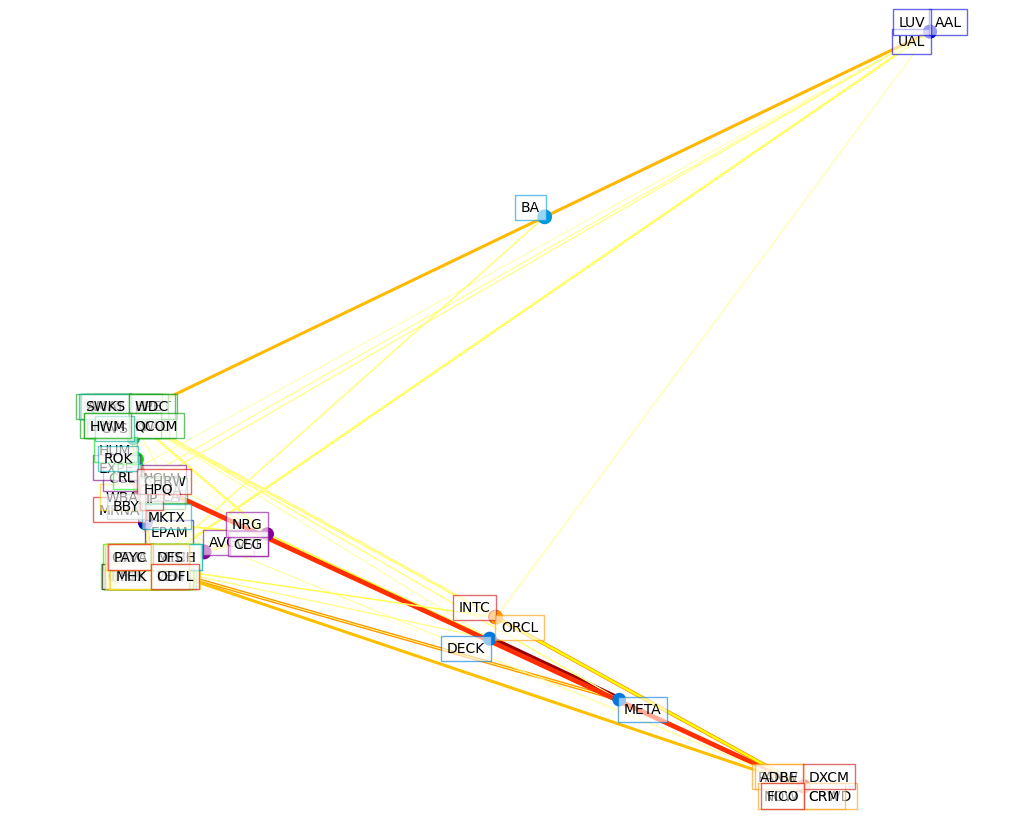

In [80]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")

# Plot the graph of partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

# Plot the nodes using the coordinates of our embedding
plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(zip(symbols, labels, embedding.T)):
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * np.ptp(embedding[0]),
    embedding[0].max() + 0.10 * np.ptp(embedding[0]),
)
plt.ylim(
    embedding[1].min() - 0.03 * np.ptp(embedding[1]),
    embedding[1].max() + 0.03 * np.ptp(embedding[1]),
)

plt.show()

In [84]:
symbols[np.argsort(partial_correlations.sum(axis=0))[:10]]

array(['BXP', 'MHK', 'NOW', 'LRCX', 'TER', 'KLAC', 'WBD', 'CZR', 'SWKS',
       'MPWR'], dtype='<U4')

# A new definition for correlation

This definition is to some degree inspired by Granger causality.
The idea is that we define a $f$ which tries to approximate Y using lagged versions of X.

$$\tilde{Y}(t) = f(X(t-1), ...,X(t-T))$$

The correlation then is defined as:

$$\rho_{X \to Y} = \lim_{\tau \to \infty} \frac{\sum_t^\tau[(Y(t) - E(Y))(\overset{\sim}{Y}(t) - E(\overset{\sim}{Y}))]}{\sqrt{\sum_t^\tau[(Y(t) - E(Y))^2]\times \sum_t^\tau[(\overset{\sim}{Y} - E(\overset{\sim}{Y}))^2]}}$$

The idea is that instead of a simple correlation, we use a stock and its lags to predict another stocks price.

Epoch 1/200


c:\Users\arash\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.2919 - val_loss: 1.1940
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2664 - val_loss: 1.1630
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2176 - val_loss: 1.1330
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2007 - val_loss: 1.1053
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1869 - val_loss: 1.0792
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1360 - val_loss: 1.0543
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1244 - val_loss: 1.0314
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1092 - val_loss: 1.0097
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0970 - val_loss: 0.9889
Epoch 10/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0739 - val_loss: 0.9696
Epoch 11/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0411 - val_loss: 0.9510
Epoch 12/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0220 - val_l

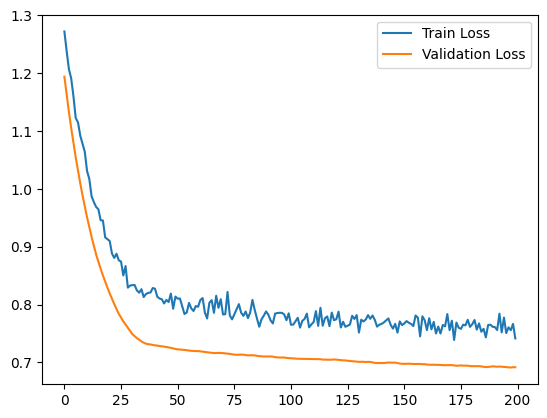

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2
import matplotlib.pyplot as plt

# This type of correlation can never be negative as it predicts the value of the other timeseries not the negative of the other time series. So this correlation can only be between 0 and 1 and negative values are erronous

ticker_1 = 'GL'
ticker_2 = 'AAPL'

# Download data from Yahoo Finance
#ko = yf.download(ticker_1, start='2024-06-15', end='2024-07-18', interval='1h')['Adj Close']
#pep = yf.download(ticker_2, start='2024-06-15', end='2024-07-18', interval='1h')['Adj Close']


# Calculate daily returns
#ko_returns = ko.pct_change().dropna()
#pep_returns = pep.pct_change().dropna()

# Generate synthetic data for KO
np.random.seed(42)
ko_returns = np.random.normal(0, 1, 400)

# Generate synthetic data for PEP
pep_returns = - 0.25 * np.hstack([np.array([0, 0]), ko_returns[:-2]])  - 0.25 * np.hstack([np.array([0]), ko_returns[:-1]])  + 0.5 * np.random.normal(0, 1, 400)

# Synchronize data
data = pd.DataFrame({ticker_1: ko_returns, ticker_2: pep_returns}).dropna()

# Create sequences of data
sequence_length = 2  # Increased sequence length

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length].values) # only the past values not the current value
        y.append(data.iloc[i+sequence_length].values)
    return np.array(X), np.array(y)

# Standardize data using the same scaler for train and test
scaler1 = StandardScaler()
scaler2 = StandardScaler()

data[[ticker_1]] = scaler1.fit_transform(data[[ticker_1]])
data[[ticker_2]] = scaler2.fit_transform(data[[ticker_2]])

# Prepare data for f1 and f2
X1, y2 = create_sequences(data[[ticker_1]], sequence_length)
X2, y1 = create_sequences(data[[ticker_2]], sequence_length)

# Split data chronologically (80% train, 20% test)
split_index1 = int(0.8 * len(X1))
split_index2 = int(0.8 * len(X2))
X1_train, X1_test = X1[:split_index1], X1[split_index1:]
y1_train, y1_test = y1[:split_index1], y1[split_index1:]
X2_train, X2_test = X2[:split_index2], X2[split_index2:]
y2_train, y2_test = y2[:split_index2], y2[split_index2:]

cov_norm_1_list = []
cov_norm_2_list = []
kernel_regularizer = l1(0.05)
epochs = 200
batch_size=32

# Define custom loss function
def custom_loss(y_true, y_pred):
    mean_error = tf.reduce_mean(tf.square(y_pred - y_true))
    return mean_error

for seed in [81]:
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Define and train LSTM model for f1
    model1 = Sequential([
        LSTM(10, return_sequences=False, input_shape=(sequence_length, X1_train.shape[-1]), kernel_regularizer=kernel_regularizer),
        Dropout(0.2),
        #LSTM(20),
        #Dropout(0.2),
        Dense(1)
    ])

    model1.compile(optimizer='adam', loss=custom_loss)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history1 = model1.fit(X1_train, y1_train, validation_data=(X1_test, y1_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

    # Define and train LSTM model for f2
    model2 = Sequential([
        LSTM(10, return_sequences=False, input_shape=(sequence_length, X2_train.shape[-1]), kernel_regularizer=kernel_regularizer),
        Dropout(0.2),
        #LSTM(20),
        #Dropout(0.2),
        Dense(1)
    ])

    model2.compile(optimizer='adam', loss=custom_loss)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history2 = model2.fit(X2_train, y2_train, validation_data=(X2_test, y2_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

    # Make predictions
    y1_pred = model1.predict(X1_test)
    y2_pred = model2.predict(X2_test)

    # Inverse transform the predictions
    y1_pred_inv = scaler2.inverse_transform(y1_pred)
    y2_pred_inv = scaler1.inverse_transform(y2_pred)

    # Calculate normalized covariance
    def normalized_covariance(y_true, y_pred):
        return np.cov(y_true.flatten(), y_pred.flatten())[0, 1] / (np.std(y_true.flatten()) * np.std(y_pred.flatten()))

    cov_norm_1 = normalized_covariance(y1_test, y1_pred_inv)
    cov_norm_2 = normalized_covariance(y2_test, y2_pred_inv)

    cov_norm_1_list.append(cov_norm_1)
    cov_norm_2_list.append(cov_norm_2)

    print(f"Normalized Covariance for f1: {cov_norm_1}")
    print(f"Normalized Covariance for f2: {cov_norm_2}")

    # Determine causality
    if cov_norm_1 > cov_norm_2:
        print(f"{ticker_1} has a stronger causal influence on {ticker_2}.")
    else:
        print(f"{ticker_2} has a stronger causal influence on {ticker_1}.")

plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [2]:
y1_pred = model1.predict(X1_test)
y2_pred = model2.predict(X2_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


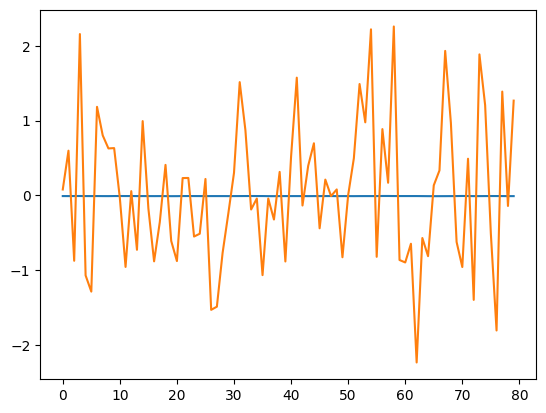

In [3]:
plt.plot(y2_pred)
plt.plot(y2_test)

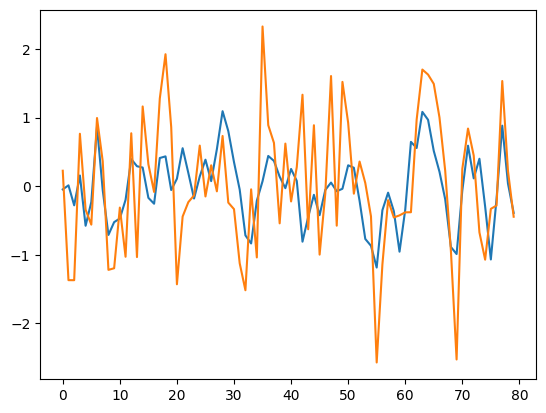

In [4]:
plt.plot(y1_pred)
plt.plot(y1_test)

In [304]:
print(np.mean(cov_norm_1_list), np.mean(cov_norm_2_list))

0.564227212086632 -0.02227104652571568


In [305]:
data.corr()

,GL,AAPL
GL,1.000000,-0.074354
AAPL,-0.074354,1.000000
